# **Year 3 project - Optimising the stability of a catalyst**

**Data Loading + imports**

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from matminer.featurizers.conversions import StrToComposition
from pymatgen.ext.matproj import MPRester
from sklearn.linear_model import LinearRegression
from IPython.display import display
initial_df = pd.read_csv(r'Python import.csv')
#display(initial_df)

**Data exploration**

In [59]:
def dataset_info(dataset):
    print(dataset.columns)
    print(dataset.describe())
    print(dataset.info())
    display(dataset)

**Data cleaning functions**

In [60]:
#This function will replace '-' values for zeroes. Also replace Nan values with zeroes
def parse_Nan(dataset):
    parse_datatset = dataset.replace('-',0) 
    parse_datatset = parse_datatset.fillna(0)
    return parse_datatset
#This function will count all the zeroes in the dataframe
def count_zeroes(df):
    return (df == 0).sum()

In [61]:
#filter columns that are required for us. Also convert some object columns to floats
def column_cleaning(dataset):
    columns_to_keep = ["Catalyst Materials","Family","ΔGOH*","ΔGO*","ΔGOOH*","Overpotential at xx (nearby) current density vs RHE, V","Reaction (HER, HRR, OER, ORR)"]
    updated_data = dataset.loc[:,columns_to_keep]
    columns_to_int = ["ΔGOH*","ΔGO*","ΔGOOH*","Overpotential at xx (nearby) current density vs RHE, V"]
    updated_data[columns_to_int] = updated_data[columns_to_int].astype(float)
    return updated_data

**Launching cleaning functions on datasets + further exploration**

In [62]:
#Launching functions
initial_df = parse_Nan(initial_df)
zeroes_df = count_zeroes(initial_df)
display(zeroes_df) 
updated_data = column_cleaning(initial_df)

# Finding information on catalyst families and reaction types 
print(updated_data['Family'].value_counts())
print(updated_data['Reaction (HER, HRR, OER, ORR)'].value_counts())

Catalyst Materials                                           0
Family                                                      48
Substrate                                                  917
Operating Conditions (T, pH, potential)                     28
Valence state, A                                           206
Valence state, B                                           206
Ionic radius A                                             206
Ionic radius B                                             206
ΔGOH*                                                      180
ΔGO*                                                       180
ΔGOOH*                                                     180
Adsorption strength                                       1006
Stable hours/cycles                                        942
Tafel Slope, mV per decade                                 903
Overpotential at xx (nearby) current density vs RHE, V      53
Reaction (HER, HRR, OER, ORR)                          

Perovskite                                     826
0                                               48
Bimetallic oxide                                26
Noble metal                                     23
Transition metal dichalcogenide                 18
Noble metal oxide                               16
2D TMD, 2H                                       9
2D TMD, 1T                                       7
Transition metal phosphide                       4
Transition metal oxide                           4
Metal alloy oxide                                3
Transition metal chalcogenide                    3
Transition metal                                 2
Metal dicalcogenide                              2
Metal dichalcogenide                             2
Transition metal carbide, in carbon martix5      2
Transition metal phosphate                       2
Noble bimetallic alloy                           2
Metal oxide                                      2
Metal phosphate                

**Adding reaction pathway energy differences**

In [63]:
updated_data['ΔGO*-ΔGOH*'] = updated_data['ΔGO*'] - updated_data['ΔGOH*']
updated_data['ΔGOOH*-ΔGO*'] = updated_data['ΔGOOH*'] - updated_data['ΔGO*']

#Slicing only data with values for required columns, then plotting dataset
updated_data = updated_data.loc[updated_data["ΔGO*-ΔGOH*"] != 0.0 ]
dataset_info(updated_data)
#print(updated_data.describe())

Index(['Catalyst Materials', 'Family', 'ΔGOH*', 'ΔGO*', 'ΔGOOH*',
       'Overpotential at xx (nearby) current density vs RHE, V',
       'Reaction (HER, HRR, OER, ORR)', 'ΔGO*-ΔGOH*', 'ΔGOOH*-ΔGO*'],
      dtype='object')
            ΔGOH*        ΔGO*      ΔGOOH*  \
count  831.000000  831.000000  831.000000   
mean     0.863430    2.635584    4.055343   
std      0.896564    1.575981    0.749906   
min     -2.840000   -2.960000    0.830000   
25%      0.280000    1.610000    3.530000   
50%      0.880000    2.680000    4.070000   
75%      1.490000    3.785000    4.580000   
max      2.930000    5.800000    5.840000   

       Overpotential at xx (nearby) current density vs RHE, V  ΔGO*-ΔGOH*  \
count                                         831.000000       831.000000   
mean                                            1.385692         1.772154   
std                                             0.461869         0.805186   
min                                             0.260000       

,Catalyst Materials,Family,ΔGOH*,ΔGO*,ΔGOOH*,"Overpotential at xx (nearby) current density vs RHE, V","Reaction (HER, HRR, OER, ORR)",ΔGO*-ΔGOH*,ΔGOOH*-ΔGO*
3,AgAlO3,Perovskite,2.18,4.63,5.10,1.82,OER,2.45,0.47
4,AgBiO3,Perovskite,1.09,3.37,4.23,1.55,OER,2.28,0.86
7,AgCoO3,Perovskite,1.59,3.28,4.66,0.92,OER,1.69,1.38
8,AgCrO3,Perovskite,0.83,2.36,4.26,1.31,OER,1.53,1.90
9,AgCuO3,Perovskite,1.80,4.36,4.79,1.38,OER,2.56,0.43
...,...,...,...,...,...,...,...,...,...
1006,YTaO3,Perovskite,-0.34,1.06,3.24,1.96,OER,1.40,2.18
1007,YTiO3,Perovskite,1.49,3.97,4.61,1.54,OER,2.48,0.64
1008,YUO3,Perovskite,0.81,2.59,4.09,1.72,OER,1.78,1.50
1009,YVO3,Perovskite,0.61,1.70,3.90,1.34,OER,1.09,2.20


**Element composition featurisation**

In [64]:
#Creating a column for element composition
str_comp = StrToComposition(target_col_id='composition')
updated_data = str_comp.featurize_dataframe(updated_data, col_id='Catalyst Materials')

StrToComposition: 100%|██████████| 831/831 [00:32<00:00, 25.41it/s] 


**Accessing material ID from material project + other properties**

In [65]:
with MPRester('CmGarHKLtPCjVpEkivPDYkhRJKJiB8A7') as mpr:
    results = mpr.summary.search(formula='**O3', fields=["material_id", "formula_pretty",'band_gap','chemsys'])
    data_list = [(result.material_id, result.formula_pretty, result.band_gap,result.chemsys) for result in results]
    #print(data_list)

Retrieving SummaryDoc documents: 100%|██████████| 2544/2544 [00:00<00:00, 3213.96it/s]


In [66]:
#Sorting chemical compositions in formulas alphabetically

def alph_order(composition):
    new_formula = []
    for i in composition:
        first= []
        second= []
        temp = list(i)
        capital_pos=[]
        for x in range(0, len(temp)):
            if temp[x].isupper() == True:
                capital_pos.append(x)
        for y in range(capital_pos[0], capital_pos[1]):
                first.append(temp[y])
        for z in range(capital_pos[1], len(temp)):
                second.append(temp[z])
        first = ''.join(str(v) for v in first)
        second = ''.join(str(v) for v in second)
        compound = ''.join(str(v) for v in first)
        compound = second+first+"O3"
        new_formula.append(compound)
    return new_formula

#This function is to delete the extra O3 placed in the formulas

def remove_O3(composition):
    return [i.replace("O3", "") for i in composition]

def add_o3(composition):
    return [i + "O3" for i in composition]



**Sorting list to a dictionary**

In [67]:
formula = []
material_id = []
band_gap = []
chemsys = []
for i in data_list:
    material_id.append(i[0])
    formula.append(i[1])
    band_gap.append(i[2])
    chemsys.append(i[3])
#Creating dictionary
material_proj_data = dict((z[0], list(z[1:])) for z in zip(formula, material_id, band_gap, chemsys))
rearranged_formula = alph_order(formula)
rearranged_formula = remove_O3(rearranged_formula)
rearranged_formula = add_o3(rearranged_formula)
#Creating dictionary for re-arranged formulae
material_proj_data_rearranged = dict((z[0], list(z[1:])) for z in zip(rearranged_formula, material_id, band_gap, chemsys))
material_proj_data.update(material_proj_data_rearranged)

**Dictionary to pandas dataframe + merge with original dataset**

In [68]:
material_proj_df = pd.DataFrame.from_dict(material_proj_data, orient= 'index')
material_proj_df = material_proj_df.reset_index()
material_proj_df.columns = ["Catalyst Materials", "material id", "band gap","chemsys"]
updated_data = updated_data.merge(material_proj_df, on ='Catalyst Materials', how= 'left')

**Dataset exploration after importing data**

In [69]:
dataset_info(updated_data)

Index(['Catalyst Materials', 'Family', 'ΔGOH*', 'ΔGO*', 'ΔGOOH*',
       'Overpotential at xx (nearby) current density vs RHE, V',
       'Reaction (HER, HRR, OER, ORR)', 'ΔGO*-ΔGOH*', 'ΔGOOH*-ΔGO*',
       'composition', 'material id', 'band gap', 'chemsys'],
      dtype='object')
            ΔGOH*        ΔGO*      ΔGOOH*  \
count  831.000000  831.000000  831.000000   
mean     0.863430    2.635584    4.055343   
std      0.896564    1.575981    0.749906   
min     -2.840000   -2.960000    0.830000   
25%      0.280000    1.610000    3.530000   
50%      0.880000    2.680000    4.070000   
75%      1.490000    3.785000    4.580000   
max      2.930000    5.800000    5.840000   

       Overpotential at xx (nearby) current density vs RHE, V  ΔGO*-ΔGOH*  \
count                                         831.000000       831.000000   
mean                                            1.385692         1.772154   
std                                             0.461869         0.805186   
min

,Catalyst Materials,Family,ΔGOH*,ΔGO*,ΔGOOH*,"Overpotential at xx (nearby) current density vs RHE, V","Reaction (HER, HRR, OER, ORR)",ΔGO*-ΔGOH*,ΔGOOH*-ΔGO*,composition,material id,band gap,chemsys
0,AgAlO3,Perovskite,2.18,4.63,5.10,1.82,OER,2.45,0.47,"(Ag, Al, O)",mp-1418444,0.0000,Ag-Al-O
1,AgBiO3,Perovskite,1.09,3.37,4.23,1.55,OER,2.28,0.86,"(Ag, Bi, O)",mp-23548,0.0000,Ag-Bi-O
2,AgCoO3,Perovskite,1.59,3.28,4.66,0.92,OER,1.69,1.38,"(Ag, Co, O)",mp-753992,0.0000,Ag-Co-O
3,AgCrO3,Perovskite,0.83,2.36,4.26,1.31,OER,1.53,1.90,"(Ag, Cr, O)",NaN,NaN,NaN
4,AgCuO3,Perovskite,1.80,4.36,4.79,1.38,OER,2.56,0.43,"(Ag, Cu, O)",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
826,YTaO3,Perovskite,-0.34,1.06,3.24,1.96,OER,1.40,2.18,"(Y, Ta, O)",NaN,NaN,NaN
827,YTiO3,Perovskite,1.49,3.97,4.61,1.54,OER,2.48,0.64,"(Y, Ti, O)",mp-1443298,0.0000,O-Ti-Y
828,YUO3,Perovskite,0.81,2.59,4.09,1.72,OER,1.78,1.50,"(Y, U, O)",NaN,NaN,NaN
829,YVO3,Perovskite,0.61,1.70,3.90,1.34,OER,1.09,2.20,"(Y, V, O)",mp-1375509,1.1014,O-V-Y


**Preparing first graph**

In [70]:
def plot_scatter_reaction_path(data):
    x_variables = ['ΔGO*-ΔGOH*','ΔGO*','ΔGOH*']
    for i in x_variables:
        plt.scatter(data[i],data["Overpotential at xx (nearby) current density vs RHE, V"])
        plt.xlabel(i)
        plt.ylabel('Overpotential at xx (nearby) current density vs RHE, V')
        if i=='ΔGO*-ΔGOH*':
            plt.title('Plot for overpotential against reaction pathway')
            plt.savefig('Scatter_plots\Overpotential against reaction step (GO-GOH).png',bbox_inches='tight')
        elif i=='ΔGO*':
            plt.savefig('Scatter_plots\Overpotential against reaction step (GO).png',bbox_inches='tight')
        else:
            plt.savefig('Scatter_plots\Overpotential against reaction step (GOH).png',bbox_inches='tight')
        plt.show()

**Clustering**

In [71]:
#Creating an elbow plot to determine how many cluster will be required for model
def elbow_plot(elbow_data):
    k_rng = range(1,10)
    sse = []
    for k in k_rng:
        km = KMeans(n_clusters= k)
        km.fit(elbow_data[['ΔGO*-ΔGOH*','Overpotential at xx (nearby) current density vs RHE, V']])
        sse.append(km.inertia_)
    print(sse)
    plt.xlabel('k')
    plt.ylabel('Sum of squared error')
    plt.title('Elbow plot for SSE against number of clusters')
    plt.plot(k_rng,sse)
    plt.savefig('Scatter_plots\Elbow plot .png',bbox_inches='tight')
    plt.show()

In [72]:
#Creating cluster plot using K-means method
def cluster_df(cluster_df,n_clusters):
    color = ['black','green','purple','red','blue']
    for k in range(0,n_clusters):
        data = cluster_df[cluster_df["cluster"]==k]
        plt.scatter(data['ΔGO*-ΔGOH*'],data["Overpotential at xx (nearby) current density vs RHE, V"],c=color[k])
        # Save datasets
        if k==0:
            data.to_csv('Cluster_csv_files\Cluster_0.csv')
        elif k==1:
                data.to_csv('Cluster_csv_files\Cluster_1.csv')
        elif k==2:
            data.to_csv('Cluster_csv_files\Cluster_2.csv')
        elif k==3:
            data.to_csv('Cluster_csv_files\Cluster_3.csv')
        else:
            data.to_csv('Cluster_csv_files\Cluster_4.csv')
    plt.xlabel('ΔGO*-ΔGOH*')
    plt.ylabel('Overpotential at xx (nearby) current density vs RHE, V')
    plt.title('Plot for overpotential against reaction pathway [CLUSTERED]')
    plt.savefig('Scatter_plots\Overpotential against reaction step (with regions).png',bbox_inches='tight')
    plt.show()
    for k in range(0,n_clusters):
        data = cluster_df[cluster_df["cluster"]==k]
        plt.scatter(data['ΔGOH*'],data['ΔGOOH*'],c=color[k])
    plt.xlabel('ΔGOH*')
    plt.ylabel('ΔGOOH*')
    plt.savefig('Scatter_plots\GOH against GOOH .png',bbox_inches='tight')
    plt.show()
    for k in range(0,n_clusters):
        data = cluster_df[cluster_df["cluster"]==k]
        plt.scatter(data['ΔGO*'],data['ΔGOH*'],c=color[k])
    plt.xlabel('ΔGO*')
    plt.ylabel('ΔGOH*')
    plt.savefig('Scatter_plots\GO against GOH .png',bbox_inches='tight')
    plt.show()
    

In [73]:
# Code to form linear regression model of GOOH* against GOH*
def linear_regression_model(dataset,x,y):
    reg = LinearRegression()
    reg.fit(dataset[[x]], dataset[[y]])
    slope = reg.coef_[0][0]
    print(slope)

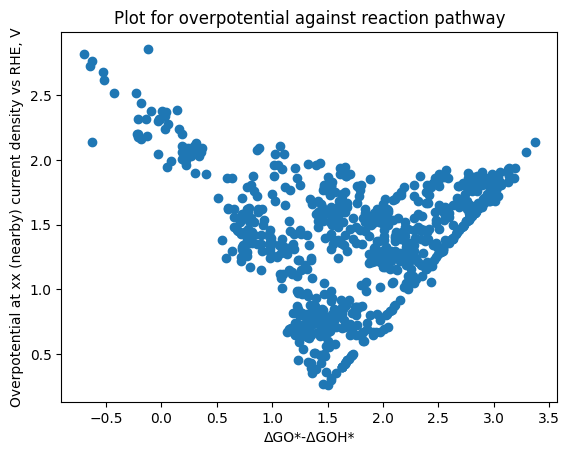

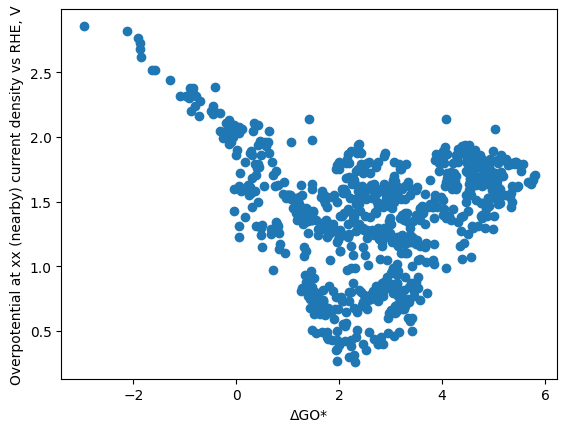

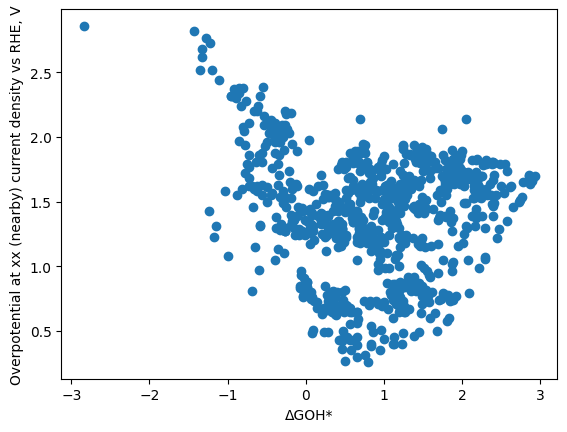

[715.1674214199759, 351.57047329051386, 198.41398654882647, 132.10847541638904, 82.57814484071653, 61.33390734725053, 54.43433914814626, 47.78550769125318, 42.71546304344888]


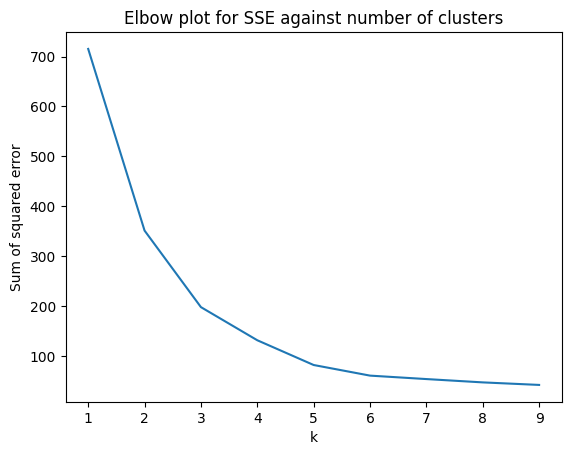

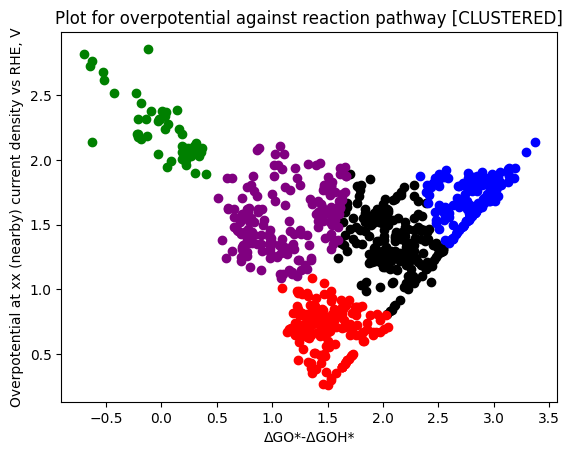

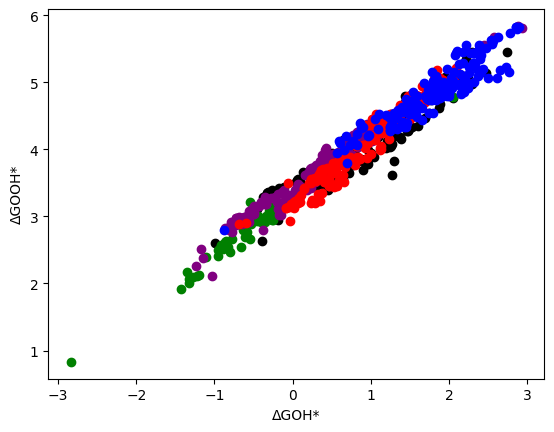

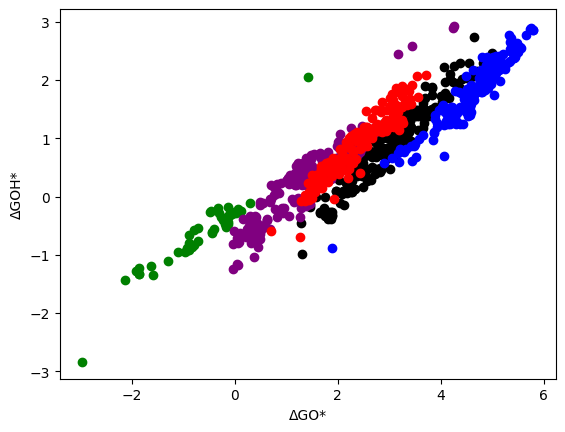

0.8164515758533752
0.5313043087091569


In [74]:
#Placing functions down
plot_scatter_reaction_path(updated_data)
elbow_plot(updated_data)
km = KMeans(n_clusters= 5)
y_predicted = km.fit_predict(updated_data[['ΔGO*-ΔGOH*','Overpotential at xx (nearby) current density vs RHE, V']])
updated_data['cluster'] = y_predicted
cluster_df(updated_data,5)
linear_regression_model(updated_data,'ΔGOH*','ΔGOOH*')
linear_regression_model(updated_data,'ΔGO*','ΔGOH*')

**Data exploration of optimum cluster**

In [75]:
#Function to determine proprtion of different catalyst materials in each dataset
def printing_stats_1(df_1,df_2,df_3):
    df_names = ['optimum catalysts','filtered initial','initial']
    data = [df_1, df_2 ,df_3]
    for i in range(0,3):
        print('The number of families in the', df_names[i], 'dataframe + normalized is:')
        print(data[i]['Family'].value_counts())
        print(data[i]['Family'].value_counts(normalize= True))

In [76]:
#Summary statistics on family data on optimum catalysts, catalyst filtered down to our data and the whole initial DF
optimum_catalyst = updated_data[updated_data['Overpotential at xx (nearby) current density vs RHE, V']<1.10]
#printing_stats_1(optimum_catalyst,updated_data,initial_df)